# Multi-city modeling of epidemics using spatial networks
Application to 2019-nCov (COVID-19) coronavirus in India

By Bhalchandra S. Pujari and Snehal Shekatkar

A network of cities, such that each city is subject to a SIR model, and they are coupled through migration rates. 
They also include delay in the equations given the distance between cities.
The outward migration rate is assumed to be proportional to the population size $\phi_i = s_i + x_i + r_i$.
Moreover the an individual in $i$ migrates to any of its neighbours with probability $1/k_i$, where $k_i$ is the number of neighbours from city $i$.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sympy as sp
from scipy.sparse.linalg import eigs

Model presentation

$$
\begin{align*}
\dot{S_i}(t) &= -\beta S_i(t) X_i(t) - \eta_i S_i(t) + \sum_{j=1}^n \eta_j\frac{A_{ij}}{k_j}\frac{\phi_j}{\phi_i}S_j(t - \delta_{ij}) - u_i(t)S_i(t) \\
\dot{X_i}(t) &= \beta S_i(t) X_i(t) - \eta_i X_i(t) + \sum_{j=1}^n \eta_j\frac{A_{ij}}{k_j}\frac{\phi_j}{\phi_i}X_j(t - \delta_{ij}) - \gamma X_i(t) \\
\dot{R_i}(t) &= \gamma X_i(t) - \eta_i R_i(t) + \sum_{j=1}^n \eta_j\frac{A_{ij}}{k_j}\frac{\phi_j}{\phi_i}R_j(t - \delta_{ij}) + u_i(t) S_i(t), 
\end{align*}
$$

such that $\phi_j$ is the population size of the $j$-th city and $k_j$ is the number of neighbours. We define $A_{ij}$ as the adjacency matrix. Finally $\delta_{ij}$ is the delay of transition between cities.

We can denote 

$$
\bar{A}_{ij} = A_{ij}\frac{\phi_j}{\phi_i k_j},
$$

to simplify the notation.

An additional assumption is that the population cities remain constant during the span of a typical epidemic, that is, 

$$
\eta_i \phi_i = \sum_{j=1}^n \eta_j A_{ij}\frac{\phi_j}{k_j} \implies \eta_i = \sum_{j=1}^n \eta_j \bar{A}_{ij}.
$$

For the implementation, define 

$$
Y = (S_1, \dots, S_n, X_1, \dots, X_n, R_1, \dots, R_n).
$$

We further assume that $\delta_{ij} = 0$.

In [2]:
def model_ode(t, y, beta, gamma, eta, A, u, N_cities): 
    s_dot, x_dot, r_dot = np.zeros(N_cities), np.zeros(N_cities), np.zeros(N_cities)
    s, x, r = y[:N_cities], y[N_cities:2*N_cities], y[2*N_cities:]
    for i in range(N_cities):
        s_dot[i] = -beta[i] * s[i] * x[i] - eta[i] * s[i] + (A[i,:]*eta*s).sum() - u(t)[i] * s[i]
        x_dot[i] = beta[i] * s[i] * x[i] - eta[i] * x[i] + (A[i,:]*eta*x).sum() - gamma * x[i]
        r_dot[i] = gamma * x[i] + u(t)[i] * s[i] - eta[i] * r[i] + (A[i,:]*eta*r).sum()
    return np.hstack([s_dot, x_dot, r_dot])

Modelling the city structure: we have a capital, and $n$ cities around.

We consider that we have $n-1$ periferic cities with $\phi_j$ each, and a capital with $\phi_0$. The matrix will be 

$$
A = \begin{bmatrix}
    0 & 1 & 1 & 1 & \cdots & 1 \\
    1 & 0 & 0 & 0 & \cdots & 0 \\
    1 & 0 & 0 & 0 & \cdots & 0 \\
    1 & 0 & 0 & 0 & \cdots & 0 \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & 0 & 0 & 0 & \cdots & 0
\end{bmatrix}
$$

Then

In [4]:
def adjacency_matrix(N_cities):
    A = np.zeros((N_cities,N_cities))
    A[0,:]=1
    A[:,0]=1
    A[0,0]=0
    return A

def create_matrix(N_cities, phi0, phij):
    A = adjacency_matrix(N_cities)
    for i in range(1,N_cities):
        A[0,i] = phij/phi0
        A[i,0] = phi0/phij/(N_cities-1)
    return A

In this network structure $\eta_j = A_{j0} \eta_0$ for $j=1,\dots,n-1$ and $\eta_0 = \sum_{k=1}^{n-1} A_{0k} \eta_k$. It remains to define $\eta_0$. 

In [42]:
N_cities = 10
phi0=1e6
phij = 1e4
A = create_matrix(N_cities=N_cities, phi0=phi0, phij=phij)
beta = 0.1*np.ones(N_cities)
beta[0] = 1.0
gamma = 0.07

eta = np.zeros(N_cities)
eta[0] = 0.01
eta[1:] = A[1:, 0] * eta[0]

For the control, we start consideting $u_j = 0$ for every city. 

In [43]:
u = lambda t: np.zeros(N_cities)#np.array([0.9, 0.1, 0, 0 ,0, 0, 0, 0, 0, 0])

Initial conditions: 

$I_0(0) = 100/\phi_0, I_j(1) = 0$

In [44]:
y0 = np.zeros(3*N_cities)
y0[:N_cities] = 1
y0[N_cities] = 100/1e6
y0[0] = 1-y0[N_cities]

In [45]:
t_eval = np.linspace(0, 5, 100)

sol = solve_ivp(fun=model_ode,
                t_span=(0,5),
                y0=y0,
                method='RK45',
                t_eval=t_eval, 
                args = (beta, gamma, eta, A, u, N_cities)
               )

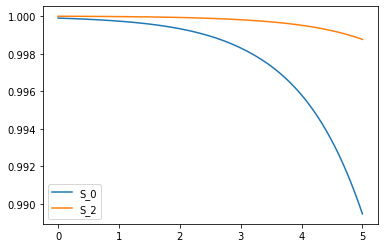

In [46]:
plt.plot(sol.t, sol.y[0], label='S_0')
plt.plot(sol.t, sol.y[2], label='S_2')
plt.legend()
plt.show()

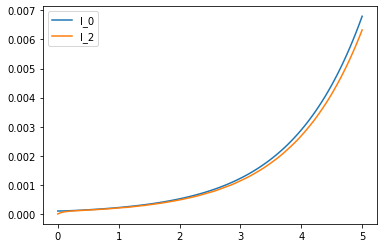

In [31]:
plt.plot(sol.t, sol.y[N_cities], label='I_0')
plt.plot(sol.t, sol.y[N_cities+2], label='I_2')
plt.legend()
plt.show()

## $R_0$ global 

Using the definition $R_0 = \rho(FV^{-1})$ from P van den Driessche.
Since $F = \beta I_n$, we have that 
$$
FV^{-1}x = \lambda x \implies V^{-1}x = (\lambda/\beta)x \implies (\beta/\lambda)x = Vx
$$
Therefore, if $\mu$ is eigenvalue of $V$, we have that $\lambda = \beta/\mu$ is eigenvalue of $R_0$. 
We want 

$$\max |\lambda| = \beta \max |\mu^{-1}| \implies R_0 = \beta/\min |\mu|$$

In [114]:
# The simplest method
def reproductive_number(beta, gamma, eta, A, N_cities):
    F = beta * np.eye(N_cities)
    V = (A - np.eye(N_cities))@np.diag(eta) - gamma * np.eye(N_cities)
    M = F@np.linalg.inv(V)
    lambd = eigs(M, k=1, which='LM', return_eigenvectors=False)
    return abs(lambd[0])

# The summarized method.
def reproductive_number2(beta, gamma, eta, A, N_cities):
    K = np.diag(np.diag(A@A))
    C = (A@np.linalg.inv(K) - np.eye(N_cities))@np.diag(eta)
    lambd = max(beta/(abs(np.linalg.eigvals(C) - gamma)))
    return lambd

In [115]:
beta = 0.2
gamma = 0.07

eta = np.zeros(N_cities)
eta[0] = 1.0
eta[1:] = A[1:, 0] * eta[0]

lambd = reproductive_number(beta, gamma, eta, A, N_cities)
lambd2 = reproductive_number2(beta, gamma, eta, adjacency_matrix(N_cities), N_cities)

print('The R0 without migration: {}'.format(beta/gamma))
print('The R0 with migration, simple implementation: {}'.format(lambd))
print('The R0 with migration, simplified implementation: {}'.format(lambd2))

The R0 without migration: 2.857142857142857
The R0 with migration, simple implementation: 2.8571428571428408
The R0 with migration, simplified implementation: 2.857142857142857


The second method is crearly a numerical error. 